<a href="https://colab.research.google.com/github/for-x-tears/MLhomeworkLU/blob/main/%D0%BD%D0%BE%D0%B2%D0%B0%D1%8F_%D0%BF%D0%BE%D0%BF%D1%8B%D1%82%D0%BA%D0%B0_%D0%BE%D0%B1%D1%83%D1%87%D0%B8%D1%82%D1%8C_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D1%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ===============================================
# ИНСТРУКЦИЯ ПО ЗАПУСКУ
# ===============================================
# 1. Откройте Google Colab (colab.research.google.com)
# 2. Включите GPU: Runtime → Change runtime type → GPU → Save
# 3. Создайте новый notebook
# 4. Скопируйте весь этот код в ячейку
# 5. Загрузите файлы через Files слева:
#      - convert.csv (для обучения)
#      - test_3in1.csv (тест с метками эмоций)
#      - test_2in1.csv (тест с метками sentiment)
# 6. Запустите код (Ctrl+Enter)
# 7. Ожидайте 15-30 минут
# ===============================================

# Шаг 1: Установка библиотек
print("📦 Установка библиотек...")
!pip install -q transformers datasets scikit-learn accelerate

# Шаг 2: Импорт
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from datasets import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

print("✅ Библиотеки загружены")

# ==================================================
# ФУНКЦИЯ ДЛЯ БЕЗОПАСНОГО ЧТЕНИЯ CSV
# ==================================================
def read_csv_safe(filepath):
    """
    Читает CSV с обработкой сложных случаев:
    - Кавычки в данных
    - Запятые внутри полей
    - Разные форматы
    """
    print(f"\n📄 Чтение файла: {filepath}")

    if not os.path.exists(filepath):
        raise FileNotFoundError(f"❌ Файл '{filepath}' не найден! Загрузите его в Colab.")

    # Попытка 1: Стандартное чтение
    try:
        df = pd.read_csv(filepath)
        print(f"   ✓ Стандартное чтение: {len(df)} строк, {len(df.columns)} колонок")
        print(f"   Колонки: {list(df.columns)}")

        # ВАЖНО: Проверяем, правильно ли распарсились данные
        if len(df.columns) == 3 and 'review' in df.columns and 'emotion' in df.columns:
            # Проверяем, есть ли NaN в emotion
            nan_count = df['emotion'].isna().sum()
            if nan_count > len(df) * 0.5:  # Если больше 50% NaN
                print(f"   ⚠ Обнаружено {nan_count} NaN в emotion - неправильный парсинг!")
                print(f"   → Переключаемся на ручной парсинг...")
                raise ValueError("Нужен ручной парсинг")

        return df
    except Exception as e:
        print(f"   ⚠ Проблема: {e}")

    # Попытка 2: Ручной парсинг
    try:
        print("   → Используем ручной парсинг...")
        data = []

        with open(filepath, 'r', encoding='utf-8') as f:
            lines = f.readlines()

            # Пропускаем заголовок
            for i, line in enumerate(lines[1:], 1):
                line = line.strip()
                if not line:
                    continue

                # Убираем внешние кавычки, если есть
                if line.startswith('"') and line.endswith('"'):
                    line = line[1:-1]

                # Ищем последние две запятые (для sentiment и emotion)
                # Формат: "текст с запятыми,sentiment,emotion"
                parts = line.rsplit(',', 2)  # Разбиваем справа на 3 части

                if len(parts) == 3:
                    review, sentiment, emotion = parts
                    data.append({
                        'review': review.strip().strip('"'),
                        'sentiment': sentiment.strip().strip('"'),
                        'emotion': emotion.strip().strip('"')
                    })
                elif len(parts) == 2:
                    # Возможно формат: review,sentiment (для test_2in1.csv)
                    review, sentiment = parts
                    data.append({
                        'review': review.strip().strip('"'),
                        'sentiment': sentiment.strip().strip('"'),
                        'emotion': None
                    })
                else:
                    print(f"   ⚠ Строка {i} пропущена (части={len(parts)}): {line[:80]}...")

        if len(data) == 0:
            raise ValueError("Не удалось распарсить ни одной строки")

        df = pd.DataFrame(data)
        print(f"   ✓ Ручной парсинг: {len(df)} строк, {len(df.columns)} колонок")
        print(f"   Колонки: {list(df.columns)}")

        # Показываем первые 3 строки для проверки
        print(f"\n   Примеры распарсенных данных:")
        for i in range(min(3, len(df))):
            print(f"   {i+1}. review: '{df.iloc[i]['review'][:50]}...'")
            print(f"      sentiment: '{df.iloc[i]['sentiment']}'")
            if 'emotion' in df.columns and df.iloc[i]['emotion'] is not None:
                print(f"      emotion: '{df.iloc[i]['emotion']}'")
        print()

        return df

    except Exception as e:
        print(f"   ❌ Ручной парсинг не удался: {e}")
        raise ValueError(f"Не удалось прочитать файл {filepath}. Проверьте формат.")

# ==================================================
# ШАГ 3: ЗАГРУЗКА ОБУЧАЮЩИХ ДАННЫХ (convert.csv)
# ==================================================
print("\n" + "="*60)
print("📊 ЗАГРУЗКА ОБУЧАЮЩИХ ДАННЫХ")
print("="*60)

df = read_csv_safe('convert.csv')

print(f"\n🔍 ДИАГНОСТИКА ДАННЫХ:")
print(f"   Всего строк: {len(df)}")
print(f"   Колонки: {list(df.columns)}")
print(f"\n   Первые 3 строки:")
for i in range(min(3, len(df))):
    print(f"   {i+1}. review: '{df.iloc[i]['review'][:50]}...'")
    print(f"      sentiment: '{df.iloc[i]['sentiment']}'")
    print(f"      emotion: '{df.iloc[i]['emotion']}'")
print()

# Проверяем наличие нужных колонок
required_cols = ['review', 'emotion']
missing = [col for col in required_cols if col not in df.columns]
if missing:
    print(f"❌ Отсутствуют колонки: {missing}")
    print(f"   Доступные колонки: {list(df.columns)}")
    raise ValueError(f"Не хватает колонок: {missing}")

# Определяем валидные значения
VALID_SENTIMENTS = {'positive', 'negative', 'neutral'}
VALID_EMOTIONS = {
    'anger', 'joy', 'sadness', 'fear', 'disgust',
    'surprise', 'neutral', 'interest', 'guilt', 'average'
}

# Очистка данных с диагностикой
print("🧹 Очистка данных:")
df = df[['review', 'sentiment', 'emotion']].copy()
print(f"   После выбора колонок: {len(df)} строк")

# Проверяем NaN
print(f"   NaN в review: {df['review'].isna().sum()}")
print(f"   NaN в emotion: {df['emotion'].isna().sum()}")
df = df.dropna(subset=['review', 'emotion'])
print(f"   После удаления NaN: {len(df)} строк")

# Преобразуем в строки
df['review'] = df['review'].astype(str)
df['emotion'] = df['emotion'].astype(str)
df['sentiment'] = df['sentiment'].astype(str)

# Strip
df['review'] = df['review'].str.strip()
df['emotion'] = df['emotion'].str.strip()
df['sentiment'] = df['sentiment'].str.strip()

# Удаляем пустые
df = df[df['review'] != '']
df = df[df['emotion'] != '']
print(f"   После удаления пустых: {len(df)} строк")

# ========== ФИЛЬТРАЦИЯ ВАЛИДНЫХ ЗНАЧЕНИЙ ==========
print(f"\n🔍 Фильтрация валидных значений:")

# Проверяем невалидные sentiment
invalid_sentiments = df[~df['sentiment'].isin(VALID_SENTIMENTS)]
if len(invalid_sentiments) > 0:
    print(f"   ⚠️  Найдено {len(invalid_sentiments)} невалидных sentiment:")
    sentiment_counts = invalid_sentiments['sentiment'].value_counts()
    for sent, count in sentiment_counts.items():
        print(f"      - '{sent}': {count}")

# Проверяем невалидные emotion
invalid_emotions = df[~df['emotion'].isin(VALID_EMOTIONS)]
if len(invalid_emotions) > 0:
    print(f"   ⚠️  Найдено {len(invalid_emotions)} невалидных emotion:")
    emotion_counts = invalid_emotions['emotion'].value_counts()
    for emo, count in emotion_counts.items():
        print(f"      - '{emo}': {count}")
    print(f"\n   Примеры строк с невалидными эмоциями:")
    for i, row in invalid_emotions.head(3).iterrows():
        print(f"      {i}. '{row['review'][:50]}...' → emotion='{row['emotion']}'")

# Фильтруем только валидные значения
df = df[df['sentiment'].isin(VALID_SENTIMENTS)]
print(f"   ✅ После фильтрации sentiment: {len(df)} строк")

df = df[df['emotion'].isin(VALID_EMOTIONS)]
print(f"   ✅ После фильтрации emotion: {len(df)} строк")

if len(df) == 0:
    print("\n❌ КРИТИЧЕСКАЯ ОШИБКА: Все строки были отфильтрованы!")
    raise ValueError("Нет данных после фильтрации валидных значений.")

print(f"\n✅ Итого валидных записей: {len(df)}")
print(f"\n📊 Распределение эмоций (после фильтрации):")
emotion_counts = df['emotion'].value_counts()
for emotion, count in emotion_counts.items():
    print(f"   {emotion:15s}: {count:4d} ({count/len(df)*100:.1f}%)")

print(f"\n📊 Распределение sentiment:")
sentiment_counts = df['sentiment'].value_counts()
for sentiment, count in sentiment_counts.items():
    print(f"   {sentiment:15s}: {count:4d} ({count/len(df)*100:.1f}%)")

# Маппинг эмоций
emotion_labels = sorted(df['emotion'].unique())
emotion2id = {e: i for i, e in enumerate(emotion_labels)}
id2emotion = {i: e for e, i in emotion2id.items()}
df['label'] = df['emotion'].map(emotion2id)

print(f"\n🏷️  Всего эмоций: {len(emotion_labels)}")
print(f"   Маппинг: {emotion2id}")

# Разделение на train/val
train_df, val_df = train_test_split(
    df,
    test_size=0.15,
    random_state=42,
    stratify=df['label']
)

print(f"\n✅ Разделение данных:")
print(f"   Train: {len(train_df)} записей")
print(f"   Val:   {len(val_df)} записей")

# ==================================================
# ШАГ 4: ТОКЕНИЗАЦИЯ И МОДЕЛЬ
# ==================================================
print("\n" + "="*60)
print("🔧 ПОДГОТОВКА МОДЕЛИ")
print("="*60)

model_name = "MaxKazak/ruBert-base-russian-emotion-detection"
print(f"Загрузка: {model_name}")

tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(
        examples['review'],
        padding='max_length',
        truncation=True,
        max_length=128
    )

print("Токенизация датасетов...")
train_dataset = Dataset.from_pandas(train_df[['review', 'label']]).map(tokenize_function, batched=True)
val_dataset = Dataset.from_pandas(val_df[['review', 'label']]).map(tokenize_function, batched=True)

print("Загрузка модели...")

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(emotion_labels),
    id2label=id2emotion,
    label2id=emotion2id,
    problem_type="single_label_classification",
    ignore_mismatched_sizes=True
)


print(f"✅ Модель создана с {len(emotion_labels)} классами эмоций")
print("✅ Модель готова к обучению")

📦 Установка библиотек...
✅ Библиотеки загружены

📊 ЗАГРУЗКА ОБУЧАЮЩИХ ДАННЫХ

📄 Чтение файла: convert.csv
   ✓ Стандартное чтение: 1266 строк, 3 колонок
   Колонки: ['review', 'sentiment', 'emotion']

🔍 ДИАГНОСТИКА ДАННЫХ:
   Всего строк: 1266
   Колонки: ['review', 'sentiment', 'emotion']

   Первые 3 строки:
   1. review: 'ГДЕ МОЙ БАГАЖ СУКИ Я УЖЕ 4 ЧАСА ЖДУ...'
      sentiment: 'negative'
      emotion: 'anger'
   2. review: 'багаж не пришел... рейс SU1234 из Дубая, прилетели...'
      sentiment: 'negative'
      emotion: 'sadness'
   3. review: 'Вы серьезно??? Чемодан синий с наклейкой потеряли ...'
      sentiment: 'negative'
      emotion: 'anger'

🧹 Очистка данных:
   После выбора колонок: 1266 строк
   NaN в review: 0
   NaN в emotion: 0
   После удаления NaN: 1266 строк
   После удаления пустых: 1266 строк

🔍 Фильтрация валидных значений:
   ✅ После фильтрации sentiment: 1266 строк
   ✅ После фильтрации emotion: 1266 строк

✅ Итого валидных записей: 1266

📊 Распределение эмоци

Map:   0%|          | 0/1076 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Загрузка модели...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at MaxKazak/ruBert-base-russian-emotion-detection and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([9]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([9, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Модель создана с 10 классами эмоций
✅ Модель готова к обучению


In [ ]:
# ==================================================
# ШАГ 5: ОБУЧЕНИЕ
# ==================================================
print("\n" + "="*60)
print("🚀 ОБУЧЕНИЕ МОДЕЛИ")
print("="*60)

# ОТКЛЮЧАЕМ WANDB
import os
os.environ["WANDB_DISABLED"] = "true"

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = np.argmax(predictions, axis=1)

    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')

    # Precision для каждой эмоции
    precision_per_class = precision_score(labels, preds, average=None)

    metrics = {
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

    for idx, emotion in id2emotion.items():
        metrics[f'precision_{emotion}'] = precision_per_class[idx]

    return metrics

training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=9,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    save_total_limit=2,
    logging_steps=50,
    warmup_steps=100,
    fp16=torch.cuda.is_available(),
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

print("Начало обучения...")
print("-" * 60)
trainer.train()
print("-" * 60)
print("✅ Обучение завершено!")


🚀 ОБУЧЕНИЕ МОДЕЛИ
Начало обучения...
------------------------------------------------------------


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Precision Anger,Precision Average,Precision Disgust,Precision Fear,Precision Guilt,Precision Interest,Precision Joy,Precision Neutral,Precision Sadness,Precision Surprise
1,2.172400,1.773165,0.351341,0.426316,0.341873,0.356164,0.000000,0.000000,0.812500,0.000000,0.000000,0.000000,0.400000,0.333333,1.000000
2,1.691700,1.025114,0.761179,0.747368,0.722855,0.608696,0.000000,0.750000,0.937500,1.000000,1.000000,0.758621,0.676923,1.000000,1.000000
3,0.677700,0.682195,0.825588,0.831579,0.812555,0.790698,0.000000,0.600000,1.000000,1.000000,0.933333,0.781250,0.807692,1.000000,0.928571
4,0.442200,0.612046,0.832391,0.842105,0.828140,0.868421,0.000000,0.615385,1.000000,1.000000,1.000000,0.750000,0.811321,0.750000,0.928571
5,0.274600,0.583650,0.859268,0.852632,0.852184,0.897436,0.750000,0.571429,1.000000,1.000000,1.000000,0.814815,0.840000,0.571429,0.928571
6,0.121100,0.613376,0.855809,0.842105,0.845266,0.914286,0.750000,0.583333,1.000000,1.000000,1.000000,0.814815,0.823529,0.500000,0.928571
7,0.078300,0.651855,0.855558,0.842105,0.844135,0.914286,0.750000,0.615385,1.000000,1.000000,1.000000,0.840000,0.811321,0.454545,0.928571


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

------------------------------------------------------------
✅ Обучение завершено!



🎯 ОЦЕНКА НА test_3in1.csv (С МЕТКАМИ ЭМОЦИЙ)

📄 Чтение файла: test_3in1.csv
   ✓ Стандартное чтение: 1165 строк, 3 колонок
   Колонки: ['review', 'sentiment', 'emotion']
✅ Загружено тестовых записей: 1165


Map:   0%|          | 0/1165 [00:00<?, ? examples/s]


CLASSIFICATION REPORT — test_3in1.csv
              precision    recall  f1-score   support

       anger      0.775     0.857     0.814       293
     average      0.857     0.643     0.735        28
     disgust      0.586     0.631     0.607        65
        fear      0.593     0.516     0.552        31
       guilt      1.000     1.000     1.000        10
    interest      0.562     0.290     0.383        31
         joy      0.687     0.896     0.778       211
     neutral      0.847     0.743     0.792       401
     sadness      0.776     0.551     0.644        69
    surprise      0.857     0.692     0.766        26

    accuracy                          0.762      1165
   macro avg      0.754     0.682     0.707      1165
weighted avg      0.768     0.762     0.758      1165


PRECISION ПО ЭМОЦИЯМ (Цель: ≥0.8)
⚠️ anger          : 0.775
✅ average        : 0.857
⚠️ disgust        : 0.586
⚠️ fear           : 0.593
✅ guilt          : 1.000
⚠️ interest       : 0.562
⚠️ joy       

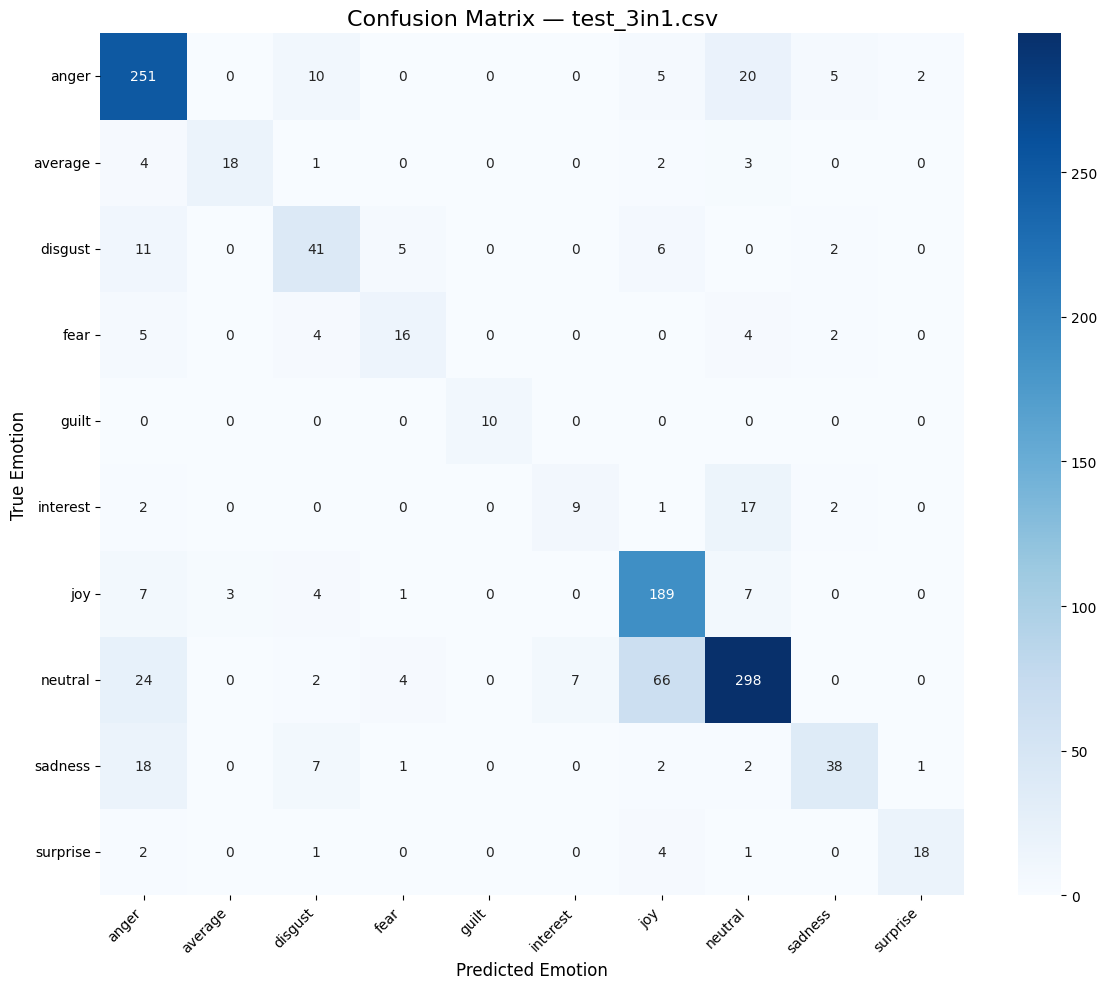

✅ Сохранено: 'confusion_matrix_test_3in1.png'

🔮 ПРЕДСКАЗАНИЯ ДЛЯ test_2in1.csv (БЕЗ МЕТОК ЭМОЦИЙ)

📄 Чтение файла: test_2in1.csv
   ✓ Стандартное чтение: 1165 строк, 2 колонок
   Колонки: ['review', 'sentiment']
✅ Загружено записей для предсказания: 1165


Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



📝 Первые 10 предсказаний:
------------------------------------------------------------

1. Текст: Где мой рюкзак с документами? Уже сутки без него!...
   Sentiment: negative
   → Предсказанная эмоция: anger
   → Уверенность: 0.905

2. Текст: Рейс AK789, багаж не прилетел, что дальше делать?...
   Sentiment: negative
   → Предсказанная эмоция: anger
   → Уверенность: 0.778

3. Текст: Сломали коляску ребенка при транспортировке, возмутительно...
   Sentiment: negative
   → Предсказанная эмоция: disgust
   → Уверенность: 0.500

4. Текст: Багаж нашли через 3 дня, но с повреждениями...
   Sentiment: negative
   → Предсказанная эмоция: anger
   → Уверенность: 0.806

5. Текст: Пятый звонок в службу, никто не отвечает...
   Sentiment: negative
   → Предсказанная эмоция: anger
   → Уверенность: 0.959

6. Текст: Доставили багаж вовремя, спасибо команде!...
   Sentiment: positive
   → Предсказанная эмоция: joy
   → Уверенность: 0.953

7. Текст: Привык к потерям, просто жду новостей...
   Sentime

Device set to use cuda:0


✅ Модель сохранена в './emotion_model_finetuned'

🧪 ТЕСТИРОВАНИЕ НА ПРИМЕРАХ

Текст: ГДЕ МОЙ БАГАЖ СУКИ
→ Эмоция: anger (уверенность: 0.960)
------------------------------------------------------------

Текст: Спасибо огромное, все отлично!
→ Эмоция: joy (уверенность: 0.953)
------------------------------------------------------------

Текст: Рейс задерживается на 6 часов
→ Эмоция: anger (уверенность: 0.969)
------------------------------------------------------------

Текст: багаж не пришел...
→ Эмоция: anger (уверенность: 0.940)
------------------------------------------------------------

Текст: Спасибо что помогли, очень приятно
→ Эмоция: joy (уверенность: 0.953)
------------------------------------------------------------

🎉 ВСЁ ГОТОВО!

📋 Что сделано:
   ✅ Обучена модель на convert.csv
   ✅ Оценка на test_3in1.csv (с метками)
   ✅ Предсказания для test_2in1.csv
   ✅ Модель сохранена в './emotion_model_finetuned'

📂 Созданные файлы:
   - confusion_matrix_test_3in1.png
   - test_2i

In [ ]:
# ==================================================
# ШАГ 6: ОЦЕНКА НА test_3in1.csv (С МЕТКАМИ)
# ==================================================
print("\n" + "="*60)
print("🎯 ОЦЕНКА НА test_3in1.csv (С МЕТКАМИ ЭМОЦИЙ)")
print("="*60)

if os.path.exists('test_3in1.csv'):
    try:
        test_3in1 = read_csv_safe('test_3in1.csv')

        # Проверяем колонки
        if 'review' in test_3in1.columns and 'emotion' in test_3in1.columns:
            test_3in1 = test_3in1[['review', 'sentiment', 'emotion']].copy()
            test_3in1 = test_3in1.dropna(subset=['review', 'emotion'])
            test_3in1['review'] = test_3in1['review'].astype(str).str.strip()
            test_3in1['emotion'] = test_3in1['emotion'].astype(str).str.strip()
            test_3in1 = test_3in1[test_3in1['review'] != '']

            # Маппинг эмоций (только известные)
            test_3in1['label'] = test_3in1['emotion'].map(emotion2id)
            test_3in1 = test_3in1[test_3in1['label'].notna()].copy()
            test_3in1['label'] = test_3in1['label'].astype(int)

            print(f"✅ Загружено тестовых записей: {len(test_3in1)}")

            if len(test_3in1) > 0:
                # Предсказания
                test_ds = Dataset.from_pandas(test_3in1[['review']]).map(tokenize_function, batched=True)
                pred = trainer.predict(test_ds)
                y_pred = np.argmax(pred.predictions, axis=1)
                y_true = test_3in1['label'].values

                # Метрики
                print("\n" + "="*60)
                print("CLASSIFICATION REPORT — test_3in1.csv")
                print("="*60)
                print(classification_report(
                    y_true, y_pred,
                    target_names=emotion_labels,
                    digits=3
                ))

                # Precision по эмоциям
                print("\n" + "="*60)
                print("PRECISION ПО ЭМОЦИЯМ (Цель: ≥0.8)")
                print("="*60)
                precision_per_class = precision_score(y_true, y_pred, average=None)
                for idx, emotion in id2emotion.items():
                    status = "✅" if precision_per_class[idx] >= 0.8 else "⚠️"
                    print(f"{status} {emotion:15s}: {precision_per_class[idx]:.3f}")

                # Общие метрики
                print("\n" + "="*60)
                print("ОБЩИЕ МЕТРИКИ")
                print("="*60)
                print(f"Weighted Precision: {precision_score(y_true, y_pred, average='weighted'):.3f}")
                print(f"Weighted Recall:    {recall_score(y_true, y_pred, average='weighted'):.3f}")
                print(f"Weighted F1:        {f1_score(y_true, y_pred, average='weighted'):.3f}")
                print(f"Accuracy:           {(y_pred == y_true).mean():.3f}")

                # Confusion Matrix
                print("\n📊 Создание Confusion Matrix...")
                cm = confusion_matrix(y_true, y_pred)
                plt.figure(figsize=(12, 10))
                sns.heatmap(
                    cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=emotion_labels,
                    yticklabels=emotion_labels
                )
                plt.title('Confusion Matrix — test_3in1.csv', fontsize=16)
                plt.ylabel('True Emotion', fontsize=12)
                plt.xlabel('Predicted Emotion', fontsize=12)
                plt.xticks(rotation=45, ha='right')
                plt.yticks(rotation=0)
                plt.tight_layout()
                plt.savefig('confusion_matrix_test_3in1.png', dpi=300, bbox_inches='tight')
                plt.show()
                print("✅ Сохранено: 'confusion_matrix_test_3in1.png'")
            else:
                print("⚠️ Нет валидных записей после фильтрации")
        else:
            print(f"⚠️ Отсутствуют нужные колонки. Найдено: {list(test_3in1.columns)}")
    except Exception as e:
        print(f"❌ Ошибка при обработке test_3in1.csv: {e}")
else:
    print("⚠️ Файл test_3in1.csv не найден — пропуск оценки")

# ==================================================
# ШАГ 7: ПРЕДСКАЗАНИЯ ДЛЯ test_2in1.csv (БЕЗ ЭМОЦИЙ)
# ==================================================
print("\n" + "="*60)
print("🔮 ПРЕДСКАЗАНИЯ ДЛЯ test_2in1.csv (БЕЗ МЕТОК ЭМОЦИЙ)")
print("="*60)

if os.path.exists('test_2in1.csv'):
    try:
        test_2in1 = read_csv_safe('test_2in1.csv')

        if 'review' in test_2in1.columns:
            test_2in1 = test_2in1[['review', 'sentiment']].copy()
            test_2in1 = test_2in1.dropna(subset=['review'])
            test_2in1['review'] = test_2in1['review'].astype(str).str.strip()
            test_2in1 = test_2in1[test_2in1['review'] != '']

            print(f"✅ Загружено записей для предсказания: {len(test_2in1)}")

            if len(test_2in1) > 0:
                from transformers import pipeline
                classifier = pipeline(
                    'text-classification',
                    model=model,
                    tokenizer=tokenizer,
                    device=0 if torch.cuda.is_available() else -1
                )

                print("\n📝 Первые 10 предсказаний:")
                print("-" * 60)
                for idx, row in test_2in1.head(10).iterrows():
                    res = classifier(row['review'])[0]
                    print(f"\n{idx+1}. Текст: {row['review'][:70]}...")
                    print(f"   Sentiment: {row['sentiment']}")
                    print(f"   → Предсказанная эмоция: {res['label']}")
                    print(f"   → Уверенность: {res['score']:.3f}")

                # Сохраняем все предсказания
                print("\n💾 Сохранение всех предсказаний...")
                predictions = []
                for text in test_2in1['review']:
                    res = classifier(text)[0]
                    predictions.append({
                        'emotion': res['label'],
                        'confidence': res['score']
                    })

                test_2in1['predicted_emotion'] = [p['emotion'] for p in predictions]
                test_2in1['confidence'] = [p['confidence'] for p in predictions]
                test_2in1.to_csv('test_2in1_predictions.csv', index=False)
                print("✅ Сохранено: 'test_2in1_predictions.csv'")
            else:
                print("⚠️ Нет записей после фильтрации")
        else:
            print(f"⚠️ Колонка 'review' не найдена. Найдено: {list(test_2in1.columns)}")
    except Exception as e:
        print(f"❌ Ошибка при обработке test_2in1.csv: {e}")
else:
    print("⚠️ Файл test_2in1.csv не найден — пропуск предсказаний")

# ==================================================
# ШАГ 8: СОХРАНЕНИЕ МОДЕЛИ
# ==================================================
print("\n" + "="*60)
print("💾 СОХРАНЕНИЕ МОДЕЛИ")
print("="*60)

model.save_pretrained('./emotion_model_finetuned')
tokenizer.save_pretrained('./emotion_model_finetuned')
print("✅ Модель сохранена в './emotion_model_finetuned'")

# ==================================================
# ШАГ 9: ТЕСТОВЫЕ ПРИМЕРЫ
# ==================================================
print("\n" + "="*60)
print("🧪 ТЕСТИРОВАНИЕ НА ПРИМЕРАХ")
print("="*60)

test_examples = [
    "ГДЕ МОЙ БАГАЖ СУКИ",
    "Спасибо огромное, все отлично!",
    "Рейс задерживается на 6 часов",
    "багаж не пришел...",
    "Спасибо что помогли, очень приятно"
]

from transformers import pipeline
classifier = pipeline(
    'text-classification',
    model=model,
    tokenizer=tokenizer,
    device=0 if torch.cuda.is_available() else -1
)

for text in test_examples:
    result = classifier(text)[0]
    print(f"\nТекст: {text}")
    print(f"→ Эмоция: {result['label']} (уверенность: {result['score']:.3f})")
    print("-" * 60)

# ==================================================
# ИТОГИ
# ==================================================
print("\n" + "="*60)
print("🎉 ВСЁ ГОТОВО!")
print("="*60)
print("\n📋 Что сделано:")
print("   ✅ Обучена модель на convert.csv")
print("   ✅ Оценка на test_3in1.csv (с метками)")
print("   ✅ Предсказания для test_2in1.csv")
print("   ✅ Модель сохранена в './emotion_model_finetuned'")
print("\n📂 Созданные файлы:")
print("   - confusion_matrix_test_3in1.png")
print("   - test_2in1_predictions.csv")
print("   - ./emotion_model_finetuned/ (папка с моделью)")
print("\n💡 Советы:")
print("   - Если precision < 0.8, увеличьте num_train_epochs до 7-10")
print("   - Попробуйте learning_rate 3e-5 или 5e-5")
print("   - Проверьте баланс классов в данных")
print("\n" + "="*60)

In [ ]:
# В Colab
!pip install huggingface_hub

from huggingface_hub import notebook_login
notebook_login()  # Войдите в свой аккаунт HF

# Загружаем модель
model.push_to_hub("forxtears/airline-emotion-classifier")
tokenizer.push_to_hub("forxtears/airline-emotion-classifier")



Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...6ytyt1_/model.safetensors:   0%|          |  552kB /  713MB            

README.md: 0.00B [00:00, ?B/s]

CommitInfo(commit_url='https://huggingface.co/forxtears/airline-emotion-classifier/commit/0047b536ace1cb17a2c8e7a7b86851d0de1b7ad0', commit_message='Upload tokenizer', commit_description='', oid='0047b536ace1cb17a2c8e7a7b86851d0de1b7ad0', pr_url=None, repo_url=RepoUrl('https://huggingface.co/forxtears/airline-emotion-classifier', endpoint='https://huggingface.co', repo_type='model', repo_id='forxtears/airline-emotion-classifier'), pr_revision=None, pr_num=None)